In [22]:
import networkx as nx
from collections import defaultdict

# >>> ajuste aqui <<<
gexf_path_covot = "../data/networks/covoting-network-20251217-150245.gexf"

# carregar rede
GV = nx.read_gexf(gexf_path_covot)

gexf_path_coauth = "../data/networks/coauthorship-network-2019_2020_2021_2022-fixed.gexf"

# carregar rede
GC = nx.read_gexf(gexf_path_coauth)

In [23]:
def align_graphs_on_common_nodes(GC: nx.Graph, GV: nx.Graph, weight_attr: str = "weight"):
    """
    Alinha duas redes pelo conjunto de nós em comum (IDs).
    Retorna subgrafos induzidos na interseção e alguns diagnósticos.

    GC: rede de coautoria (ponderada)
    GV: rede de covotação (ponderada)
    weight_attr: nome do atributo de peso nas arestas
    """

    # 1) Interseção de nós
    nodes_C = set(GC.nodes())
    nodes_V = set(GV.nodes())
    common = nodes_C & nodes_V

    if len(common) == 0:
        raise ValueError("Nenhum nó em comum entre GC e GV. Verifique se os IDs são realmente os mesmos tipos/formatos.")

    # 2) Subgrafos induzidos
    GC_I = GC.subgraph(common).copy()
    GV_I = GV.subgraph(common).copy()

    # 3) Garantir que peso existe e é numérico (quando possível)
    def _sanitize_weights(G):
        missing = 0
        non_numeric = 0
        for u, v, data in G.edges(data=True):
            if weight_attr not in data:
                missing += 1
                data[weight_attr] = 1.0
                continue
            w = data[weight_attr]
            try:
                data[weight_attr] = float(w)
            except (TypeError, ValueError):
                non_numeric += 1
                data[weight_attr] = 1.0
        return missing, non_numeric

    miss_C, nonnum_C = _sanitize_weights(GC_I)
    miss_V, nonnum_V = _sanitize_weights(GV_I)

    diagnostics = {
        "GC_nodes_before": GC.number_of_nodes(),
        "GV_nodes_before": GV.number_of_nodes(),
        "common_nodes": len(common),
        "GC_nodes_after": GC_I.number_of_nodes(),
        "GV_nodes_after": GV_I.number_of_nodes(),
        "GC_edges_after": GC_I.number_of_edges(),
        "GV_edges_after": GV_I.number_of_edges(),
        "GC_missing_weight_filled": miss_C,
        "GV_missing_weight_filled": miss_V,
        "GC_non_numeric_weight_fixed": nonnum_C,
        "GV_non_numeric_weight_fixed": nonnum_V,
    }

    return GC_I, GV_I, common, diagnostics


# ===== EXEMPLO DE USO =====
# 


In [24]:
GC_I, GV_I, common_nodes, diag = align_graphs_on_common_nodes(GC, GV, weight_attr="weight")
print(diag)

{'GC_nodes_before': 637, 'GV_nodes_before': 613, 'common_nodes': 613, 'GC_nodes_after': 613, 'GV_nodes_after': 613, 'GC_edges_after': 45046, 'GV_edges_after': 169824, 'GC_missing_weight_filled': 0, 'GV_missing_weight_filled': 0, 'GC_non_numeric_weight_fixed': 0, 'GV_non_numeric_weight_fixed': 0}


In [25]:
import numpy as np
import pandas as pd

def build_pair_table(GC_I, GV_I, common_nodes, weight_attr="weight", max_pairs=None):
    """
    Cria uma tabela de pares (i,j) com pesos de coautoria e covotação.
    Para pares sem aresta, peso = 0.

    max_pairs: se não for None, amostra aleatoriamente esse número de pares
              (útil se N for grande e N*(N-1)/2 ficar pesado).
    """
    nodes = sorted(list(common_nodes))
    n = len(nodes)

    # total de pares
    total_pairs = n * (n - 1) // 2

    # índice dos nós
    idx = {node: k for k, node in enumerate(nodes)}

    # função para obter peso de aresta (0 se não existe)
    def edge_weight_or_zero(G, u, v):
        if G.has_edge(u, v):
            data = G.get_edge_data(u, v)
            # em MultiGraph, get_edge_data retorna dict de chaves -> attrs
            if isinstance(data, dict) and any(isinstance(val, dict) for val in data.values()):
                # pega soma dos pesos em multiarestas
                w = 0.0
                for _, attrs in data.items():
                    w += float(attrs.get(weight_attr, 1.0))
                return w
            return float(data.get(weight_attr, 1.0))
        return 0.0

    # Se for amostrar pares
    if max_pairs is not None and max_pairs < total_pairs:
        rng = np.random.default_rng(123)
        # amostra índices de pares no espaço triangular
        # estratégia simples: amostra (a,b) até completar, com set para evitar repetição
        seen = set()
        pairs = []
        while len(pairs) < max_pairs:
            i = int(rng.integers(0, n))
            j = int(rng.integers(0, n))
            if i == j:
                continue
            a, b = (i, j) if i < j else (j, i)
            if (a, b) in seen:
                continue
            seen.add((a, b))
            pairs.append((nodes[a], nodes[b]))
    else:
        # todos os pares
        pairs = []
        for a in range(n):
            u = nodes[a]
            for b in range(a + 1, n):
                v = nodes[b]
                pairs.append((u, v))

    rows = []
    for u, v in pairs:
        rows.append({
            "u": u,
            "v": v,
            "vote_w": edge_weight_or_zero(GV_I, u, v),
            "coauth_w": edge_weight_or_zero(GC_I, u, v),
        })

    df_pairs = pd.DataFrame(rows)

    # diagnósticos úteis
    diagnostics = {
        "n_nodes_common": n,
        "n_pairs_used": len(df_pairs),
        "vote_edge_rate": float((df_pairs["vote_w"] > 0).mean()),
        "coauth_edge_rate": float((df_pairs["coauth_w"] > 0).mean()),
        "vote_weight_sum": float(df_pairs["vote_w"].sum()),
        "coauth_weight_sum": float(df_pairs["coauth_w"].sum()),
    }

    return df_pairs, diagnostics


# ===== EXEMPLO DE USO =====
# 


In [26]:
df_pairs, diag_pairs = build_pair_table(GC_I, GV_I, common_nodes, weight_attr="weight", max_pairs=None)
print(diag_pairs)
df_pairs.head()

{'n_nodes_common': 613, 'n_pairs_used': 187578, 'vote_edge_rate': 0.9053513738284874, 'coauth_edge_rate': 0.2401454328332747, 'vote_weight_sum': 5012979.0, 'coauth_weight_sum': 58638.0}


,u,v,vote_w,coauth_w
0,105534,107283,1.0,0.0
1,105534,108338,3.0,0.0
2,105534,109429,3.0,0.0
3,105534,112437,3.0,0.0
4,105534,115746,3.0,0.0


In [27]:
import pandas as pd
from collections import defaultdict
import itertools

def build_vote_similarity(
    votes_csv_path,
    common_nodes,
    valid_votes=("Sim", "Não"),
    deputy_col="deputado_id",
    vote_id_col="idVotacao",
    vote_col="voto",
):
    df = pd.read_csv(votes_csv_path)

    diag = {
        "rows_total": int(len(df)),
        "cols": list(df.columns),
    }

    # normalizar IDs para string em ambos os lados
    common_str = set(str(x).strip() for x in common_nodes)

    # deputado_id pode vir como int; converte para string
    df[deputy_col] = df[deputy_col].astype(str).str.strip()

    # diagnóstico de interseção
    sample_csv_ids = set(df[deputy_col].head(2000).tolist())
    diag["example_csv_ids_head"] = list(sorted(list(sample_csv_ids)))[0:10]
    diag["example_common_ids"] = list(sorted(list(common_str)))[0:10]
    diag["n_common_overlap_with_csv_head"] = int(len(sample_csv_ids & common_str))

    # filtrar deputados na interseção
    df = df[df[deputy_col].isin(common_str)].copy()
    diag["rows_after_common_nodes_filter"] = int(len(df))

    # filtrar votos válidos (com strip para garantir)
    df[vote_col] = df[vote_col].astype(str).str.strip()
    df = df[df[vote_col].isin(valid_votes)].copy()
    diag["rows_after_valid_votes_filter"] = int(len(df))

    out_cols = ["u", "v", "n_common_votes", "n_equal_votes", "vote_similarity"]
    if len(df) == 0:
        diag["reason_empty"] = "Após filtros, não sobrou nenhuma linha. Verifique se common_nodes realmente contém deputado_id e se valid_votes está correto."
        diag["vote_value_counts_all"] = df[vote_col].value_counts(dropna=False).to_dict()
        return pd.DataFrame(columns=out_cols), diag

    # agora processar por votação
    n_common = defaultdict(int)
    n_equal = defaultdict(int)

    # agrupar por votação
    for _, g in df.groupby(vote_id_col):
        votes = list(zip(g[deputy_col].tolist(), g[vote_col].tolist()))
        if len(votes) < 2:
            continue

        for (i, vi), (j, vj) in itertools.combinations(votes, 2):
            a, b = (i, j) if i < j else (j, i)
            n_common[(a, b)] += 1
            if vi == vj:
                n_equal[(a, b)] += 1

    if len(n_common) == 0:
        diag["reason_empty"] = "Nenhum par compartilhou votações válidas (após filtros)."
        return pd.DataFrame(columns=out_cols), diag

    rows = []
    for (i, j), c in n_common.items():
        eq = n_equal.get((i, j), 0)
        rows.append({
            "u": i,
            "v": j,
            "n_common_votes": c,
            "n_equal_votes": eq,
            "vote_similarity": eq / c
        })

    df_sim = pd.DataFrame(rows)

    diag["n_pairs_output"] = int(len(df_sim))
    diag["mean_common_votes"] = float(df_sim["n_common_votes"].mean())
    diag["median_common_votes"] = float(df_sim["n_common_votes"].median())
    diag["mean_similarity"] = float(df_sim["vote_similarity"].mean())

    return df_sim, diag


# ===== USO =====
# 



In [28]:
df_vote_sim, diag_vote = build_vote_similarity(
     votes_csv_path="../data/votes_detail_info.csv",
     common_nodes=common_nodes,  # o mesmo que você usou antes
     valid_votes=("Sim","Não")
 )
print(diag_vote)
df_vote_sim.head()

{'rows_total': 49136, 'cols': ['idVotacao', 'uriVotacao', 'dataHoraVoto', 'voto', 'deputado_id', 'deputado_uri', 'deputado_nome', 'deputado_siglaPartido', 'deputado_uriPartido', 'deputado_siglaUf', 'deputado_idLegislatura', 'deputado_urlFoto', 'ano_votacao'], 'example_csv_ids_head': ['107283', '108338', '109429', '112437', '115746', '116379', '121948', '122158', '122974', '132504'], 'example_common_ids': ['105534', '107283', '108338', '109429', '112437', '115746', '116379', '118594', '121948', '122158'], 'n_common_overlap_with_csv_head': 514, 'rows_after_common_nodes_filter': 49136, 'rows_after_valid_votes_filter': 48817, 'n_pairs_output': 172332, 'mean_common_votes': 57.34179954970638, 'median_common_votes': 64.0, 'mean_similarity': 0.5104329993845008}


,u,v,n_common_votes,n_equal_votes,vote_similarity
0,160600,204374,80,46,0.575000
1,160600,204572,75,49,0.653333
2,141405,160600,74,35,0.472973
3,160600,204454,62,34,0.548387
4,160600,204512,84,49,0.583333


In [31]:
import pandas as pd

def coauth_edge_table(GC_I, weight_attr="weight"):
    """
    Extrai tabela de arestas (u,v) da rede de coautoria induzida,
    somando pesos se for MultiGraph.
    """
    rows = []
    is_multi = GC_I.is_multigraph()

    if is_multi:
        for u, v, key, data in GC_I.edges(keys=True, data=True):
            w = float(data.get(weight_attr, 1.0))
            rows.append((str(u).strip(), str(v).strip(), w))
        df = pd.DataFrame(rows, columns=["u", "v", "w"])
        # normalizar ordem (u < v) e somar multiarestas
        df[["u", "v"]] = df.apply(lambda r: (r["u"], r["v"]) if r["u"] < r["v"] else (r["v"], r["u"]), axis=1, result_type="expand")
        df = df.groupby(["u", "v"], as_index=False)["w"].sum().rename(columns={"w": "coauth_w"})
    else:
        for u, v, data in GC_I.edges(data=True):
            w = float(data.get(weight_attr, 1.0))
            uu, vv = (str(u).strip(), str(v).strip())
            if uu > vv:
                uu, vv = vv, uu
            rows.append((uu, vv, w))
        df = pd.DataFrame(rows, columns=["u", "v", "coauth_w"])

    return df


def build_pairs_joint(df_vote_sim, GC_I, weight_attr="weight"):
    """
    Cria tabela final por pares com:
      - vote_similarity
      - n_common_votes
      - n_equal_votes
      - coauth_w (0 se não existe aresta de coautoria)
    """
    # garantir string e ordem canônica u < v
    dfv = df_vote_sim.copy()
    dfv["u"] = dfv["u"].astype(str).str.strip()
    dfv["v"] = dfv["v"].astype(str).str.strip()
    dfv[["u", "v"]] = dfv.apply(lambda r: (r["u"], r["v"]) if r["u"] < r["v"] else (r["v"], r["u"]), axis=1, result_type="expand")

    dfc = coauth_edge_table(GC_I, weight_attr=weight_attr)

    # merge: todos os pares que têm voto em comum entram, coautoria pode ser zero
    df_joint = dfv.merge(dfc, on=["u", "v"], how="left")
    df_joint["coauth_w"] = df_joint["coauth_w"].fillna(0.0)

    diagnostics = {
        "n_pairs_joint": int(len(df_joint)),
        "coauth_edge_rate_among_vote_pairs": float((df_joint["coauth_w"] > 0).mean()),
        "mean_vote_similarity": float(df_joint["vote_similarity"].mean()),
        "mean_coauth_w": float(df_joint["coauth_w"].mean()),
        "median_coauth_w": float(df_joint["coauth_w"].median()),
        "sum_coauth_w": float(df_joint["coauth_w"].sum()),
    }

    return df_joint, diagnostics


# ===== USO =====
# 


In [34]:
df_joint, diag_joint = build_pairs_joint(df_vote_sim, GC_I, weight_attr="weight")
print(diag_joint)
df_joint.head()

{'n_pairs_joint': 172332, 'coauth_edge_rate_among_vote_pairs': 0.2612109184597173, 'mean_vote_similarity': 0.5104329993845008, 'mean_coauth_w': 0.3400819348699023, 'median_coauth_w': 0.0, 'sum_coauth_w': 58607.0}


,u,v,n_common_votes,n_equal_votes,vote_similarity,coauth_w
0,160600,204374,80,46,0.575000,1.0
1,160600,204572,75,49,0.653333,1.0
2,141405,160600,74,35,0.472973,1.0
3,160600,204454,62,34,0.548387,0.0
4,160600,204512,84,49,0.583333,0.0


In [37]:
import numpy as np

def prepare_coauth_log(df_joint):
    """
    Cria coauth_log = log(1 + coauth_w)
    e devolve diagnósticos descritivos.
    """
    df = df_joint.copy()

    df["coauth_log"] = np.log1p(df["coauth_w"])

    diagnostics = {
        "coauth_w_min": float(df["coauth_w"].min()),
        "coauth_w_median": float(df["coauth_w"].median()),
        "coauth_w_mean": float(df["coauth_w"].mean()),
        "coauth_w_max": float(df["coauth_w"].max()),
        "coauth_zero_rate": float((df["coauth_w"] == 0).mean()),
        "coauth_log_min": float(df["coauth_log"].min()),
        "coauth_log_median": float(df["coauth_log"].median()),
        "coauth_log_mean": float(df["coauth_log"].mean()),
        "coauth_log_max": float(df["coauth_log"].max()),
    }

    return df, diagnostics


# ===== USO =====
# 


In [38]:
df_joint2, diag_log = prepare_coauth_log(df_joint)
print(diag_log)
df_joint2[["coauth_w","coauth_log"]].head()

{'coauth_w_min': 0.0, 'coauth_w_median': 0.0, 'coauth_w_mean': 0.3400819348699023, 'coauth_w_max': 12.0, 'coauth_zero_rate': 0.7387890815402827, 'coauth_log_min': 0.0, 'coauth_log_median': 0.0, 'coauth_log_mean': 0.2060849428875017, 'coauth_log_max': 2.5649493574615367}


,coauth_w,coauth_log
0,1.0,0.693147
1,1.0,0.693147
2,1.0,0.693147
3,0.0,0.000000
4,0.0,0.000000


In [39]:
from scipy.stats import pearsonr
import numpy as np

def spearman_vote_coauth(df_joint2):
    """
    Calcula correlação de Pearson entre
    vote_similarity e coauth_log.
    Mantive o nome da função para você não precisar alterar a célula de uso.
    """
    x = df_joint2["vote_similarity"].values
    y = df_joint2["coauth_log"].values

    # pearsonr dá erro se uma das séries for constante
    if np.all(x == x[0]) or np.all(y == y[0]):
        r, pval = np.nan, np.nan
    else:
        r, pval = pearsonr(x, y)

    diagnostics = {
        "pearson_r": float(r) if not np.isnan(r) else np.nan,
        "pearson_pvalue_naive": float(pval) if not np.isnan(pval) else np.nan,
        "n_pairs": int(len(df_joint2)),
    }

    return diagnostics


# ===== USO =====
#



In [42]:
diag_spearman = spearman_vote_coauth(df_joint2)
print(diag_spearman)

{'pearson_r': 0.2283573738669706, 'pearson_pvalue_naive': 0.0, 'n_pairs': 172332}


In [ ]:
import numpy as np
from scipy.stats import spearmanr

def qap_spearman(
    df_joint2,
    n_permutations=1000,
    random_state=123
):
    """
    QAP simples para Spearman entre vote_similarity e coauth_log.
    Retorna estatística observada, distribuição nula e p-valor empírico.
    """

    rng = np.random.default_rng(random_state)

    # pares observados
    x_obs = df_joint2["vote_similarity"].values
    y_obs = df_joint2["coauth_log"].values

    # estatística observada
    rho_obs, _ = spearmanr(x_obs, y_obs)

    # extrair lista única de nós
    nodes = np.unique(
        np.concatenate([
            df_joint2["u"].values,
            df_joint2["v"].values
        ])
    )

    # mapear pares para índices
    pair_index = {}
    for idx, (u, v) in enumerate(zip(df_joint2["u"], df_joint2["v"])):
        pair_index[(u, v)] = idx

    # pré-alocar distribuição nula
    rho_perm = np.zeros(n_permutations)

    # para acelerar: vetor y fixo
    y = y_obs

    for k in range(n_permutations):
        perm = rng.permutation(nodes)
        perm_map = dict(zip(nodes, perm))

        # construir x permutado
        x_perm = np.empty_like(x_obs)

        for i, (u, v) in enumerate(zip(df_joint2["u"], df_joint2["v"])):
            u_p = perm_map[u]
            v_p = perm_map[v]
            a, b = (u_p, v_p) if u_p < v_p else (v_p, u_p)
            x_perm[i] = df_joint2.loc[pair_index.get((a, b), i), "vote_similarity"]

        rho_perm[k], _ = spearmanr(x_perm, y)

    # p-valor empírico (bicaudal)
    p_empirical = (
        np.sum(np.abs(rho_perm) >= abs(rho_obs)) + 1
    ) / (n_permutations + 1)

    diagnostics = {
        "rho_observed": float(rho_obs),
        "p_empirical": float(p_empirical),
        "n_permutations": n_permutations,
        "rho_perm_mean": float(np.mean(rho_perm)),
        "rho_perm_std": float(np.std(rho_perm)),
        "rho_perm_min": float(np.min(rho_perm)),
        "rho_perm_max": float(np.max(rho_perm)),
    }

    return diagnostics, rho_perm


# ===== USO =====
# 


In [ ]:
diag_qap, rho_perm = qap_spearman(
    df_joint2,
    n_permutations=1000
)
print(diag_qap)

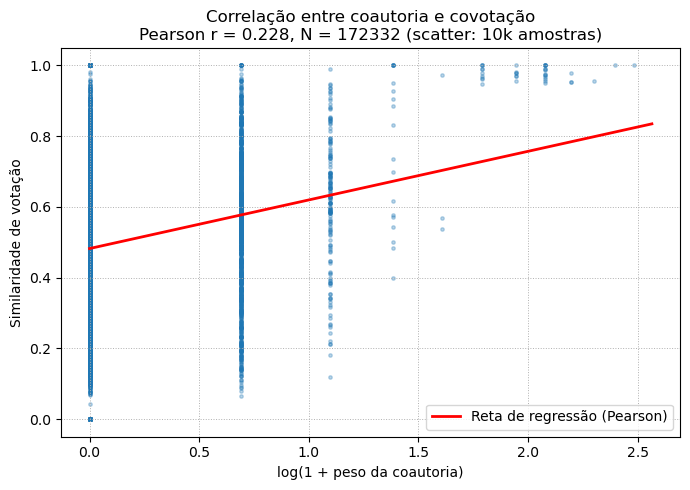

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# DADOS COMPLETOS (para a reta)
# =========================
x = df_joint2["coauth_log"].values
y = df_joint2["vote_similarity"].values

# =========================
# SUBAMOSTRAGEM PARA O SCATTER
# =========================
np.random.seed(42)

n_sample = 5_000  # recomendado
idx = np.random.choice(len(x), size=n_sample, replace=False)

x_s = x[idx]
y_s = y[idx]

# =========================
# REGRESSÃO LINEAR (reta do Pearson, com TODOS os dados)
# =========================
a, b = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = a * x_line + b

# =========================
# PLOT
# =========================
plt.figure(figsize=(7, 5))

plt.scatter(
    x_s,
    y_s,
    s=6,
    alpha=0.3,
)

plt.plot(
    x_line,
    y_line,
    color="red",
    linewidth=2,
    label="Reta de regressão (Pearson)"
)

plt.xlabel("log(1 + peso da coautoria)")
plt.ylabel("Similaridade de votação")
plt.title(
    "Correlação entre coautoria e covotação\n"
    "Pearson r = 0.228, N = 172332 (scatter: 10k amostras)"
)

plt.legend()
plt.grid(True, linestyle=":", linewidth=0.7)
plt.tight_layout()
plt.show()

